In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns



from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error

import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
train_df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
#行数の表示制限を解除
pd.set_option('display.max_rows', None)
#列数の表示制限を解除
pd.set_option('display.max_columns', None)
#表示が膨大になるので、必ず head()を設定すること。
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
#1460ID（行）と、81カラム（列）とわかる。
train_df.shape

(1460, 81)

In [4]:
#1460IDの（行）が、1460とわかる。
len(train_df)

1460

In [5]:
train_df.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1         int64
BsmtFinType2      object
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
Heating           object


### 見かけだけでカラムのデータを判断しないように、まずはカラムの種類を調べる

In [6]:
#データフレームの中身の種類を確認するときは、必ずすべてを確認するために、
#行数の表示制限を解除　pd.set_option('display.max_rows', None)
#列数の表示制限を解除　pd.set_option('display.max_columns', None)
#の表示制限解除が必要となる場合がある。

## 欠損値の確認

In [7]:
#ベースライン用に、まずは欠損値がないものを探す。
print(train_df.isnull().sum())

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType        872
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFin

## 特徴量のデータ型の確認

In [8]:
#欠損値がないかつカラムのデータ型を確認する。（RMSEの場合、object型は扱えない)
train_df.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1         int64
BsmtFinType2      object
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
Heating           object


## 学習用データ全体とテストデータ全体のバックアップ

In [9]:
#testデータの読み込みと。ID数とカラム数を表示をさせている
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
test.shape

(1459, 80)

In [10]:
train_df_backup = train_df.copy()
test_backup = test.copy()

## 特徴量の選択

In [11]:
#以下、あたりをつけた特徴量
features=["SaleCondition", "SaleType", "Functional", "MSZoning", "Neighborhood", "LotArea", "MSSubClass", "TotRmsAbvGrd", "GrLivArea", "1stFlrSF", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinSF1", "Heating", "HeatingQC", "CentralAir", "KitchenAbvGr", "KitchenQual", "ExterQual", "GarageCars", "GarageArea"]
#目的変数y_train と説明変数x_trainに分けた。ここは、まだベースラインなのでドメイン知識と欠損値がないという理由だけの説明変数の選択。
x_train = train_df[features]
y_train = train_df["SalePrice"]

print(x_train.shape)
print(y_train.shape)

(1460, 23)
(1460,)


In [12]:
features

['SaleCondition',
 'SaleType',
 'Functional',
 'MSZoning',
 'Neighborhood',
 'LotArea',
 'MSSubClass',
 'TotRmsAbvGrd',
 'GrLivArea',
 '1stFlrSF',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'KitchenAbvGr',
 'KitchenQual',
 'ExterQual',
 'GarageCars',
 'GarageArea']

## 特徴量選択後のテストデータの定義

In [13]:
#X_test を事前に読み込んだ特徴量の数（features)と設定し、表示させている。

x_test = test[features]
x_test.shape

(1459, 23)

## 特徴量選択後の学習用データとテストデータのバックアップ

In [14]:
x_train_backup = x_train.copy()

In [15]:
x_test_backup = x_test.copy()

## 特徴量 の順序付きマッピング ＠＠最初に欠損値と種類はデータフレームを作成して一覧できる！とにかく時間を短縮できそうならする！

#### 特徴量選択後の学習用データの欠損値を調べる。

In [16]:
#データフレームで、選択した特徴量の欠損件数等をあらかじめ表示させる

missing_info = pd.DataFrame({
    '欠損件数': x_train[features].isnull().sum(),
    '欠損率': x_train[features].isnull().mean()
})

# 欠損があるカラムだけ表示（任意）
missing_info = missing_info[missing_info['欠損件数'] > 0]
missing_info = missing_info.sort_values(by='欠損率', ascending=False)

missing_info

,欠損件数,欠損率
BsmtExposure,38,0.026027
BsmtQual,37,0.025342
BsmtCond,37,0.025342
BsmtFinType1,37,0.025342


#### 特徴量選択後のテストデータの欠損値を調べる。（欠損値への処理は学習用、テスト用ともに必要なので、かならずどちらも欠損値を確認する）

In [17]:
missing_info = pd.DataFrame({
    '欠損件数': x_test[features].isnull().sum(),
    '欠損率': x_test[features].isnull().mean()
})

# 欠損があるカラムだけ表示（任意）
missing_info = missing_info[missing_info['欠損件数'] > 0]
missing_info = missing_info.sort_values(by='欠損率', ascending=False)

missing_info

,欠損件数,欠損率
BsmtCond,45,0.030843
BsmtQual,44,0.030158
BsmtExposure,44,0.030158
BsmtFinType1,42,0.028787
MSZoning,4,0.002742
Functional,2,0.001371
SaleType,1,0.000685
BsmtFinSF1,1,0.000685
KitchenQual,1,0.000685
GarageCars,1,0.000685


#### 選択した特徴量の種類とそのサンプル値を確認する。（学習用データ）

In [18]:
#pandas のデフォルト表示幅制限を解除↓

summary = pd.DataFrame({
    '種類数': [x_train[col].nunique(dropna=True) for col in features],
    'サンプル値': [x_train[col].dropna().unique()[:13] for col in features]  # 最大5種表示
    }, index=features)

    
with pd.option_context('display.max_colwidth', None):
    display(summary)



,種類数,サンプル値
SaleCondition,6,"[Normal, Abnorml, Partial, AdjLand, Alloca, Family]"
SaleType,9,"[WD, New, COD, ConLD, ConLI, CWD, ConLw, Con, Oth]"
Functional,7,"[Typ, Min1, Maj1, Min2, Mod, Maj2, Sev]"
MSZoning,5,"[RL, RM, C (all), FV, RH]"
Neighborhood,25,"[CollgCr, Veenker, Crawfor, NoRidge, Mitchel, Somerst, NWAmes, OldTown, BrkSide, Sawyer, NridgHt, NAmes, SawyerW]"
LotArea,1073,"[8450, 9600, 11250, 9550, 14260, 14115, 10084, 10382, 6120, 7420, 11200, 11924, 12968]"
MSSubClass,15,"[60, 20, 70, 50, 190, 45, 90, 120, 30, 85, 80, 160, 75]"
TotRmsAbvGrd,12,"[8, 6, 7, 9, 5, 11, 4, 10, 12, 3, 2, 14]"
GrLivArea,861,"[1710, 1262, 1786, 1717, 2198, 1362, 1694, 2090, 1774, 1077, 1040, 2324, 912]"
1stFlrSF,753,"[856, 1262, 920, 961, 1145, 796, 1694, 1107, 1022, 1077, 1040, 1182, 912]"


#### 選択した特徴量の種類とそのサンプル値を確認する。（テストデータ）

In [19]:
#pandas のデフォルト表示幅制限を解除↓
summary = pd.DataFrame({
    '種類数': [x_test[col].nunique(dropna=True) for col in features],
    'サンプル値': [x_test[col].dropna().unique()[:13] for col in features]  # 最大5種表示
}, index=features)

with pd.option_context('display.max_colwidth', None):
    display(summary)


summary

,種類数,サンプル値
SaleCondition,6,"[Normal, Partial, Abnorml, Family, Alloca, AdjLand]"
SaleType,9,"[WD, COD, New, ConLD, Oth, Con, ConLw, ConLI, CWD]"
Functional,7,"[Typ, Min2, Min1, Mod, Maj1, Sev, Maj2]"
MSZoning,5,"[RH, RL, RM, FV, C (all)]"
Neighborhood,25,"[NAmes, Gilbert, StoneBr, BrDale, NPkVill, NridgHt, Blmngtn, NoRidge, Somerst, SawyerW, Sawyer, NWAmes, OldTown]"
LotArea,1106,"[11622, 14267, 13830, 9978, 5005, 10000, 7980, 8402, 10176, 8400, 5858, 1680, 2280]"
MSSubClass,16,"[20, 60, 120, 160, 80, 30, 50, 90, 85, 190, 45, 70, 75]"
TotRmsAbvGrd,12,"[5, 6, 7, 4, 10, 8, 9, 3, 12, 11, 13, 15]"
GrLivArea,879,"[896, 1329, 1629, 1604, 1280, 1655, 1187, 1465, 1341, 882, 1337, 987, 1092]"
1stFlrSF,789,"[896, 1329, 928, 926, 1280, 763, 1187, 789, 1341, 882, 1337, 483, 525]"


,種類数,サンプル値
SaleCondition,6,"[Normal, Partial, Abnorml, Family, Alloca, Adj..."
SaleType,9,"[WD, COD, New, ConLD, Oth, Con, ConLw, ConLI, ..."
Functional,7,"[Typ, Min2, Min1, Mod, Maj1, Sev, Maj2]"
MSZoning,5,"[RH, RL, RM, FV, C (all)]"
Neighborhood,25,"[NAmes, Gilbert, StoneBr, BrDale, NPkVill, Nri..."
LotArea,1106,"[11622, 14267, 13830, 9978, 5005, 10000, 7980,..."
MSSubClass,16,"[20, 60, 120, 160, 80, 30, 50, 90, 85, 190, 45..."
TotRmsAbvGrd,12,"[5, 6, 7, 4, 10, 8, 9, 3, 12, 11, 13, 15]"
GrLivArea,879,"[896, 1329, 1629, 1604, 1280, 1655, 1187, 1465..."
1stFlrSF,789,"[896, 1329, 928, 926, 1280, 763, 1187, 789, 13..."


#### Heating のマッピング

In [20]:
#学習用データの型と値の種類を確認する
print(x_train['Heating'].dtype)
print(x_train['Heating'].unique())

object
['GasA' 'GasW' 'Grav' 'Wall' 'OthW' 'Floor']


In [21]:
#テスト用データの型と種類を確認
print(x_test['Heating'].dtype)
print(x_test['Heating'].unique())

object
['GasA' 'GasW' 'Grav' 'Wall']


In [22]:

# Heating の順序付きマッピングを定義（例）数値の重みは分析管理シートから参考
# 欠損値なし版
heating_order = {
    'GasA': 5,
    'GasW': 4,
    'Grav': 1,
    'Wall': 3,  
    "OthW": 2,
    "Floor": 0,
}


# 数値へマッピング（安全で一貫性のある変換）
x_train['Heating'] = x_train['Heating'].map(heating_order)
x_test['Heating'] = x_test['Heating'].map(heating_order)

#### Heating QC のマッピング

In [23]:
##学習用データの型と値の種類を確認する
print(x_train['HeatingQC'].dtype)
print(x_train['HeatingQC'].unique())

object
['Ex' 'Gd' 'TA' 'Fa' 'Po']


In [24]:
#テスト用データの型と値の種類を確認する
print(x_test['HeatingQC'].dtype)
print(x_test['HeatingQC'].unique())

object
['TA' 'Gd' 'Ex' 'Fa' 'Po']


In [25]:
heatingQC_order = {
    'Ex': 4,
    'Gd': 3,
    'TA': 2,
    'Fa': 1,  
    "Po": 0,
}


# 数値へマッピング（安全で一貫性のある変換）
x_train['HeatingQC'] = x_train['HeatingQC'].map(heatingQC_order)
x_test['HeatingQC'] = x_test['HeatingQC'].map(heatingQC_order)

#### CentralAir	のマッピング

In [26]:
##学習用データの型と値の種類を確認する
print(x_train['CentralAir'].dtype)
print(x_train['CentralAir'].unique())

object
['Y' 'N']


In [27]:
##テスト用データの型と値の種類を確認する
print(x_test['CentralAir'].dtype)
print(x_test['CentralAir'].unique())

object
['Y' 'N']


In [28]:
CentralAir_order = {
    'Y': 1,
    'N': 0,
}


# 数値へマッピング（安全で一貫性のある変換）
x_train['CentralAir'] = x_train['CentralAir'].map(CentralAir_order)
x_test['CentralAir'] = x_test['CentralAir'].map(CentralAir_order)

#### Heating,Heating QC ,CentralAir のマッピング後のバックアップ(0709)

In [29]:
x_train_backup0709 = x_train.copy()
x_test_backup0709 = x_test.copy()

#### BsmtCondのマッピング（欠損値 train,test ともに欠損値あり）欠損値を補完したあとでないと、型の変換はできない

In [30]:
##学習用データの型と値の種類を確認する
print(x_train['BsmtCond'].dtype)
print(x_train['BsmtCond'].unique())

object
['TA' 'Gd' nan 'Fa' 'Po']


In [31]:
##テスト用データの型と値の種類を確認する
print(x_test['BsmtCond'].dtype)
print(x_test['BsmtCond'].unique())

object
['TA' 'Po' 'Fa' 'Gd' nan]


In [32]:
#BsmtCond
#[TA, Po, Fa, Gd]

BsmtCond_order = {
    'Gd': 3,
    'TA': 2,
    'Fa': 1,  
    "Po": 0,
}


# 数値へマッピング（安全で一貫性のある変換）
x_train['BsmtCond'] = x_train['BsmtCond'].map(BsmtCond_order)
x_test['BsmtCond'] = x_test['BsmtCond'].map(BsmtCond_order)

#### Heating,Heating QC,CentralAir,BsmtCond のマッピング後のバックアップ(0709_1)¶

In [33]:
x_train_backup0709_1 = x_train.copy()
x_test_backup0709_1 = x_test.copy()

#### KitchenAbvGrのマッピングint 型なので、キーとマップをintでそろえること

In [34]:
###学習用データの型と値の種類を確認する
print(x_train['KitchenAbvGr'].dtype)
print(x_train['KitchenAbvGr'].unique())

int64
[1 2 3 0]


In [35]:
###テスト用データの型と値の種類を確認する
print(x_test['KitchenAbvGr'].dtype)
print(x_test['KitchenAbvGr'].unique())

int64
[1 2 0]


In [36]:
KitchenAbvGr_order = {
     1: '2',
     2: '1',
     3: '1',  
     0: '0',
}


# 数値へマッピング（安全で一貫性のある変換）
x_train['KitchenAbvGr'] = x_train['KitchenAbvGr'].map(KitchenAbvGr_order)
x_test['KitchenAbvGr'] = x_test['KitchenAbvGr'].map(KitchenAbvGr_order)

In [37]:
#int へ戻した。
x_train['KitchenAbvGr'] = x_train['KitchenAbvGr'].astype(int)
x_test['KitchenAbvGr'] = x_test['KitchenAbvGr'].astype(int)

#### Heating, Heating QC, CentralAir, BsmtCond, KitchenAbvGr のマッピング後のバックアップ(0710)¶

In [38]:
x_train_backup0710 = x_train.copy()
x_test_backup0710 = x_test.copy()

#### KitchenQualのマッピング (欠損値TESTデータに１あり）

In [59]:
###学習用データの型と値の種類を確認する
print(x_train['KitchenQual'].dtype)
print(x_train['KitchenQual'].unique())

int64
[3 2 4 1]


In [58]:
###テストデータの型と値の種類を確認する
print(x_test['KitchenQual'].dtype)
print(x_test['KitchenQual'].unique())

float64
[ 2.  3.  4.  1. nan]


In [50]:
#KitchenQual
#TA, Gd, Ex, Fa

KitchenQual_order = {
    'Ex': 4,
    'Gd': 3,
    'TA': 2,  
    "Fa": 1,
    "Po": 0,
}


# 数値へマッピング（安全で一貫性のある変換）
x_train['KitchenQual'] = x_train['KitchenQual'].map(KitchenQual_order)
x_test['KitchenQual'] = x_test['KitchenQual'].map(KitchenQual_order)

In [57]:
x_train_backup0711 = x_train.copy()
x_test_backup0711 = x_test.copy()

#### ExterQualのマッピング欠損値なし

In [60]:
###学習用データの型と値の種類を確認する
print(x_train['ExterQual'].dtype)
print(x_train['ExterQual'].unique())

object
['Gd' 'TA' 'Ex' 'Fa']


In [61]:
###学習用データの型と値の種類を確認する
print(x_test['ExterQual'].dtype)
print(x_test['ExterQual'].unique())

object
['TA' 'Gd' 'Ex' 'Fa']


In [62]:
# ExterQual	4	[TA, Gd, Ex, Fa]
ExterQual_order = {
    'Ex': 3,
    'Gd': 2,
    'TA': 1,  
    "Fa": 0,
}


# 数値へマッピング（安全で一貫性のある変換）
x_train['ExterQual'] = x_train['ExterQual'].map(ExterQual_order)
x_test['ExterQual'] = x_test['ExterQual'].map(ExterQual_order)

In [68]:
x_train_backup0711_1 = x_train.copy()
x_test_backup0711_1 = x_test.copy()

#### BsmtQualのマッピング（欠損値　学習用、テスト共に３０以上あり）

In [69]:
###学習用データの型と値の種類を確認する
print(x_train['BsmtQual'].dtype)
print(x_train['BsmtQual'].unique())

object
['Gd' 'TA' 'Ex' nan 'Fa']


In [70]:
###テスト用データの型と値の種類を確認する
print(x_test['BsmtQual'].dtype)
print(x_test['BsmtQual'].unique())

object
['TA' 'Gd' 'Ex' 'Fa' nan]


In [71]:
#BsmtQual	4	[TA, Gd, Ex, Fa]

BsmtQual_order = {
    'Ex': 3,
    'Gd': 2,
    'TA': 1,  
    "Fa": 0,
}


# 数値へマッピング（安全で一貫性のある変換）
x_train['BsmtQual'] = x_train['BsmtQual'].map(BsmtQual_order)
x_test['BsmtQual'] = x_test['BsmtQual'].map(BsmtQual_order)

In [75]:
x_train_backup0711_2 = x_train.copy()
x_test_backup0711_2 = x_test.copy()

#### BsmtExposure　のマッピング（学習用、テスト用ともに欠損値３０以上あり）

In [76]:
###学習用データの型と値の種類を確認する
print(x_train['BsmtExposure'].dtype)
print(x_train['BsmtExposure'].unique())

object
['No' 'Gd' 'Mn' 'Av' nan]


In [77]:
###テスト用データの型と値の種類を確認する
print(x_test['BsmtExposure'].dtype)
print(x_test['BsmtExposure'].unique())

object
['No' 'Gd' 'Mn' 'Av' nan]


In [78]:
#BsmtExposure	4	[No, Gd, Mn, Av]

BsmtExposure_order = {
    'Gd': 3,
    'Av': 2,
    'Mn': 1,  
    "No": 0,
}


# 数値へマッピング（安全で一貫性のある変換）
x_train['BsmtExposure'] = x_train['BsmtExposure'].map(BsmtExposure_order)
x_test['BsmtExposure'] = x_test['BsmtExposure'].map(BsmtExposure_order)


In [82]:
x_train_backup0711_3 = x_train.copy()
x_test_backup0711_3 = x_test.copy()

In [83]:
#pandas のデフォルト表示幅制限を解除↓
summary = pd.DataFrame({
    '種類数': [x_test[col].nunique(dropna=True) for col in features],
    'サンプル値': [x_test[col].dropna().unique()[:13] for col in features]  # 最大5種表示
}, index=features)

with pd.option_context('display.max_colwidth', None):
    display(summary)


summary

,種類数,サンプル値
SaleCondition,6,"[Normal, Partial, Abnorml, Family, Alloca, AdjLand]"
SaleType,9,"[WD, COD, New, ConLD, Oth, Con, ConLw, ConLI, CWD]"
Functional,7,"[Typ, Min2, Min1, Mod, Maj1, Sev, Maj2]"
MSZoning,5,"[RH, RL, RM, FV, C (all)]"
Neighborhood,25,"[NAmes, Gilbert, StoneBr, BrDale, NPkVill, NridgHt, Blmngtn, NoRidge, Somerst, SawyerW, Sawyer, NWAmes, OldTown]"
LotArea,1106,"[11622, 14267, 13830, 9978, 5005, 10000, 7980, 8402, 10176, 8400, 5858, 1680, 2280]"
MSSubClass,16,"[20, 60, 120, 160, 80, 30, 50, 90, 85, 190, 45, 70, 75]"
TotRmsAbvGrd,12,"[5, 6, 7, 4, 10, 8, 9, 3, 12, 11, 13, 15]"
GrLivArea,879,"[896, 1329, 1629, 1604, 1280, 1655, 1187, 1465, 1341, 882, 1337, 987, 1092]"
1stFlrSF,789,"[896, 1329, 928, 926, 1280, 763, 1187, 789, 1341, 882, 1337, 483, 525]"


,種類数,サンプル値
SaleCondition,6,"[Normal, Partial, Abnorml, Family, Alloca, Adj..."
SaleType,9,"[WD, COD, New, ConLD, Oth, Con, ConLw, ConLI, ..."
Functional,7,"[Typ, Min2, Min1, Mod, Maj1, Sev, Maj2]"
MSZoning,5,"[RH, RL, RM, FV, C (all)]"
Neighborhood,25,"[NAmes, Gilbert, StoneBr, BrDale, NPkVill, Nri..."
LotArea,1106,"[11622, 14267, 13830, 9978, 5005, 10000, 7980,..."
MSSubClass,16,"[20, 60, 120, 160, 80, 30, 50, 90, 85, 190, 45..."
TotRmsAbvGrd,12,"[5, 6, 7, 4, 10, 8, 9, 3, 12, 11, 13, 15]"
GrLivArea,879,"[896, 1329, 1629, 1604, 1280, 1655, 1187, 1465..."
1stFlrSF,789,"[896, 1329, 928, 926, 1280, 763, 1187, 789, 13..."


In [ ]:
#'SaleCondition',
#'SaleType',
#'Functional',
# 'MSZoning',
# 'Neighborhood',[NAmes, Gilbert, StoneBr, BrDale, NPkVill, のような文字列なので、意味付けが必要
#'LotArea',
#'MSSubClass',　20, 60, 120, 160, 80, 30, 50, 90, 85, 190, 45, 70, 75のコード表記であるため、意味付けが必要
#'TotRmsAbvGrd',
#'GrLivArea',
#'1stFlrSF',
#'BsmtQual',　　マッピング済
#'BsmtCond',　　　マッピング済
#'BsmtExposure',  マッピング済
#'BsmtFinType1',
#'BsmtFinSF1',
#'Heating',　　マッピング済
#'HeatingQC',マッピング済
#'CentralAir',マッピング済
#'KitchenAbvGr',マッピング済
#'KitchenQual',マッピング済
#'ExterQual',マッピング済
#'GarageCars',[1.0, 2.0, 3.0, 0.0, 4.0, 5.0]の台数であり、概ね台数が多ければ評価はあがる。意味付け必要
#'GarageArea']

In [79]:
x_train.dtypes

SaleCondition     object
SaleType          object
Functional        object
MSZoning          object
Neighborhood      object
LotArea            int64
MSSubClass         int64
TotRmsAbvGrd       int64
GrLivArea          int64
1stFlrSF           int64
BsmtQual         float64
BsmtCond         float64
BsmtExposure     float64
BsmtFinType1      object
BsmtFinSF1         int64
Heating            int64
HeatingQC          int64
CentralAir         int64
KitchenAbvGr       int64
KitchenQual        int64
ExterQual          int64
GarageCars         int64
GarageArea         int64
dtype: object

In [80]:
x_train.head()

,SaleCondition,SaleType,Functional,MSZoning,Neighborhood,LotArea,MSSubClass,TotRmsAbvGrd,GrLivArea,1stFlrSF,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,Heating,HeatingQC,CentralAir,KitchenAbvGr,KitchenQual,ExterQual,GarageCars,GarageArea
0,Normal,WD,Typ,RL,CollgCr,8450,60,8,1710,856,2.0,2.0,0.0,GLQ,706,5,4,1,2,3,2,2,548
1,Normal,WD,Typ,RL,Veenker,9600,20,6,1262,1262,2.0,2.0,3.0,ALQ,978,5,4,1,2,2,1,2,460
2,Normal,WD,Typ,RL,CollgCr,11250,60,6,1786,920,2.0,2.0,1.0,GLQ,486,5,4,1,2,3,2,2,608
3,Abnorml,WD,Typ,RL,Crawfor,9550,70,7,1717,961,1.0,3.0,0.0,ALQ,216,5,3,1,2,3,1,3,642
4,Normal,WD,Typ,RL,NoRidge,14260,60,9,2198,1145,2.0,2.0,2.0,GLQ,655,5,4,1,2,3,2,3,836


In [81]:
x_test.head()

,SaleCondition,SaleType,Functional,MSZoning,Neighborhood,LotArea,MSSubClass,TotRmsAbvGrd,GrLivArea,1stFlrSF,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,Heating,HeatingQC,CentralAir,KitchenAbvGr,KitchenQual,ExterQual,GarageCars,GarageArea
0,Normal,WD,Typ,RH,NAmes,11622,20,5,896,896,1.0,2.0,0.0,Rec,468.0,5,2,1,2,2.0,1,1.0,730.0
1,Normal,WD,Typ,RL,NAmes,14267,20,6,1329,1329,1.0,2.0,0.0,ALQ,923.0,5,2,1,2,3.0,1,1.0,312.0
2,Normal,WD,Typ,RL,Gilbert,13830,60,6,1629,928,2.0,2.0,0.0,GLQ,791.0,5,3,1,2,2.0,1,2.0,482.0
3,Normal,WD,Typ,RL,Gilbert,9978,60,7,1604,926,1.0,2.0,0.0,GLQ,602.0,5,4,1,2,3.0,1,2.0,470.0
4,Normal,WD,Typ,RL,StoneBr,5005,120,5,1280,1280,2.0,2.0,0.0,ALQ,263.0,5,4,1,2,3.0,2,2.0,506.0


In [66]:
x_train.dtypes

SaleCondition     object
SaleType          object
Functional        object
MSZoning          object
Neighborhood      object
LotArea            int64
MSSubClass         int64
TotRmsAbvGrd       int64
GrLivArea          int64
1stFlrSF           int64
BsmtQual          object
BsmtCond         float64
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1         int64
Heating            int64
HeatingQC          int64
CentralAir         int64
KitchenAbvGr       int64
KitchenQual        int64
ExterQual          int64
GarageCars         int64
GarageArea         int64
dtype: object

In [67]:
x_test.dtypes

SaleCondition     object
SaleType          object
Functional        object
MSZoning          object
Neighborhood      object
LotArea            int64
MSSubClass         int64
TotRmsAbvGrd       int64
GrLivArea          int64
1stFlrSF           int64
BsmtQual          object
BsmtCond         float64
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1       float64
Heating            int64
HeatingQC          int64
CentralAir         int64
KitchenAbvGr       int64
KitchenQual      float64
ExterQual          int64
GarageCars       float64
GarageArea       float64
dtype: object

## 目的変数と説明変数の分割

In [44]:
#目的変数はSalepriceである。説明変数は、まずはベースラインように欠損値がなく、価格に重要な要素を選択する。→コンディションとセールタイプ

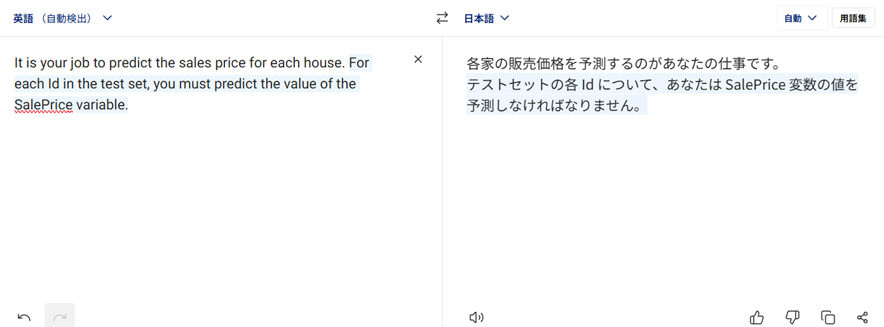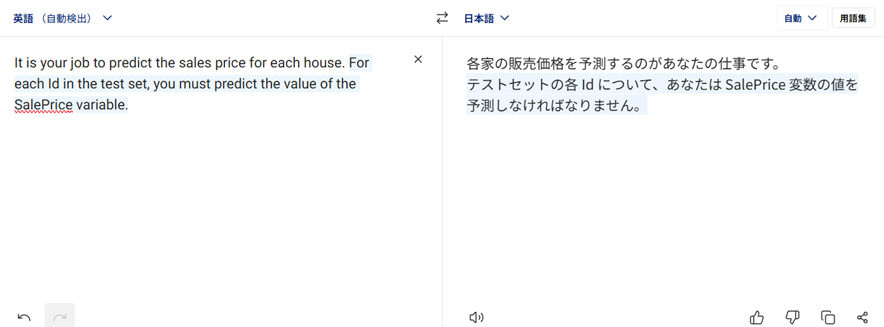

## バリデーション

### ** クロスバリデーションでの分割方法

In [45]:
#from sklearn.model_selection import train_test_split, KFold を一番上記のコードに入れる。

In [46]:
# 回帰、評価指標RMSEの場合 のパラメータの設定をする。
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.1,
    'num_leaves': 16,
    'n_estimators': 100000,
    "random_state": 123,
    "importance_type": "gain",
}

In [47]:
#n_splitsの変数 に５を事前に入れている。
n_splits = 5

#StratifiedKFoldを使って、n_splitsを、上記で設定していた n_splits=5 回分割するという意味。#cv は任意であるが、Cross　Validation の頭文字からとっている。
cv = KFold(n_splits=n_splits, shuffle=True, random_state=123)

metrics = []
imp = pd.DataFrame()

#train_idx, val_idxを事前に準備しておき、
#5分割したデータセットのインデックスを毎回のループごとに受け取れるようにした。↓
#for train_idx, val_idx in (cv.split(x_train, y_train):
#また、何番目の分割かを知りたいので、enumerateを　cv.split(x_train, y_train)に行い、
#追加して、インデックスも取得したいので、nfold, も (train_idx, val_idx)に使う。

for nfold, (train_idx, val_idx) in enumerate(cv.split(x_train)):
    print("-"*10, nfold, "-"*10)

#下記コードで、８対２（train_df内で、学習用８割、評価用２割の意味）学習用の分割にインデックスなしでデータが５分割されていることがわかる。
#本番用のtestデータはここでは分割されていない。   
    print(val_idx[:10])
    
#ここまでかけたら、split で学習用（説明変数・目的変数）と評価用（説明変数と目的変数）を
#学習用の説明変数インデックスと学習用の目的変数に対して、iloc で（行番号、列番号（ここでは２種類の説明変数））と、
#目的変数のインデックスを抽出し、x_tr と y_trに入れてあげる。(＊評価用の説明変数と目的変数のインデックスに対しても同じことをしている）

    
    x_tr, y_tr = x_train.iloc[train_idx], y_train.iloc[train_idx]
    x_va, y_va = x_train.iloc[val_idx], y_train.iloc[val_idx]

    
    print("train_df 内の学習用説明変数データ:", x_tr.shape)
    print("train_df 内の評価用説明変数データ:", x_va.shape)

    print("train_df 内の学習用目的変数データ:", y_tr.shape)
    print("train_df 内の評価用目的変数データ:", y_va.shape)

#lightGBM を選ぶ理由
#モデルの精度が高い、処理が高速、カテゴリ変数を数値に変換しなくても処理できる（*objectはカテゴリーに要変換)
#欠損値があっても学習をおこなえる、外れ値の影響を受けずらい。などがある。

#パラメータの説明

#eval_set	上記「評価指標」算出のためのデータセットを指定する引数（ここでは、デフォルトの値なので、数の指定はしていない）
#目的としては、主に学習過程を監視し、過学習を防ぐための早期停止を行うため等がある。


model = lgb.LGBMRegressor(**params)


model.fit(
        x_tr,
        y_tr,
        eval_set=[(x_tr, y_tr), (x_va, y_va)],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100, verbose=True),
            lgb.log_evaluation(0)
        ],
    )
#lighGBMはobject型は扱えないので、astypeメソッドで、category型に変換する必要がある。

---------- 0 ----------
[12 13 18 28 31 33 35 36 42 43]
train_df 内の学習用説明変数データ: (1168, 23)
train_df 内の評価用説明変数データ: (292, 23)
train_df 内の学習用目的変数データ: (1168,)
train_df 内の評価用目的変数データ: (292,)
---------- 1 ----------
[ 5  7  9 15 19 20 30 40 44 55]
train_df 内の学習用説明変数データ: (1168, 23)
train_df 内の評価用説明変数データ: (292, 23)
train_df 内の学習用目的変数データ: (1168,)
train_df 内の評価用目的変数データ: (292,)
---------- 2 ----------
[ 0  4 10 11 21 23 26 27 37 41]
train_df 内の学習用説明変数データ: (1168, 23)
train_df 内の評価用説明変数データ: (292, 23)
train_df 内の学習用目的変数データ: (1168,)
train_df 内の評価用目的変数データ: (292,)
---------- 3 ----------
[ 6 14 22 24 29 32 34 38 70 80]
train_df 内の学習用説明変数データ: (1168, 23)
train_df 内の評価用説明変数データ: (292, 23)
train_df 内の学習用目的変数データ: (1168,)
train_df 内の評価用目的変数データ: (292,)
---------- 4 ----------
[ 1  2  3  8 16 17 25 39 46 47]
train_df 内の学習用説明変数データ: (1168, 23)
train_df 内の評価用説明変数データ: (292, 23)
train_df 内の学習用目的変数データ: (1168,)
train_df 内の評価用目的変数データ: (292,)


ValueError: pandas dtypes must be int, float or bool.
Fields with bad pandas dtypes: SaleCondition: object, SaleType: object, Functional: object, MSZoning: object, Neighborhood: object, BsmtQual: object, BsmtExposure: object, BsmtFinType1: object, KitchenQual: object, ExterQual: object

## 設定したモデルでの推論・計算

In [ ]:
#精度を計算するには、モデルの推論・予測値を先に計算する必要がある。
#下記は、モデルによる学習用データを使った目的変数への精度と、モデルによる評価用データを使った目的変数への精度を計算している。
#model.predictを使ってモデルの予測値を計算して、そのあとに正解と予測値を使って正解率を計算する。
y_tr_pred = model.predict(x_tr)
y_va_pred = model.predict(x_va)

#上記でモデルの予測値の計算が終わったので、下記で、RMSEの計算を、目的変数（学習用データを使って）と目的変数（評価用データを使って）を使って行う。
rmse_tr = np.sqrt(mean_squared_error(y_tr, y_tr_pred))
rmse_va = np.sqrt(mean_squared_error(y_va, y_va_pred))

#format 関数で、rmse_tr とrmse_va の値を ｛｝内に、小数点第2位までプリントしている。＊少数点第２位（:.2f)
print("[RMSE] tr: {:.2f}, va: {:.2f}".format(rmse_tr, rmse_va))

#metrics変数に appendで　nfold, rmse_tr, rmse_va　を追加してあげる。
metrics.append([nfold, rmse_tr, rmse_va])

#
_imp = pd.DataFrame({
    "col": x_train.columns,
    "imp": model.feature_importances_,
    "nfold": nfold
})
#concatメソッドで、事前に結合したいDataframeの変数を2つ以上用意し[ ]リスト形式で記載している。
#なお、axis=0 は（デフォルトで）縦に、axis=1 は横にデータを連結する。
#引数ignore_index=Trueを指定すると、DataFrameを連結後、連結の軸方向のインデックスを無視して0から値を振り直します。(デフォルトはFalse)
imp = pd.concat([imp, _imp], axis=0, ignore_index=True)

In [ ]:
# np.arrayの応用についてにはこちら→　https://www.choge-blog.com/programming/python-numpy-array/

#ここは単純に、一次元標記のため、array を使用している。
metrics = np.array(metrics)
#すでに指定した metrics 内　の値である、「fold 回数」、「平均」、「標準偏差」 がプリントされている。
#上記は、[[4.0000000e+00 4.7772013e+04 5.1268212e+04]]の部分である。
print(metrics)

#tr: {:.2f} に metrics[:,1].mean()の値を　 va: {:.2f}にmetrics[:,1].std()の値を入れている。
#[cv ] tr: +-{:.2f}に、metrics[:,2].mean()の値を　 va: +-{:.2f}に　metrics[:,2].std()の値と入れている。
print("[cv ] tr: {:.2f}+-{:.2f}, va: {:.2f}+-{:.2f}".format(
  metrics[:,1].mean(), metrics[:,1].std(),
  metrics[:,2].mean(), metrics[:,2].std(),
))
   

In [ ]:
# groupbyでcolをグルーピング（ここでは、すでに選択した8種類）し、
#imp = pd.concat([imp, _imp], axis=0, ignore_index=True) で作成したデータフレームの imp の平均値(mean)と標準偏差(std)をaggで計算している。
#なお、agg はaggregate の意味で　「集約する」　という意味がある。
imp = imp.groupby("col")["imp"].agg(["mean", "std"])

#imp のデータフレームにカラムを追加して、上記の imp に対して agg で計算した　mean と　std　の値を入れている。
imp.columns = ["imp", "imp_std"]

#sort_values(by='imp' は、imp列を基準に並び変えるという意味。
#ascending=False は、データを昇順に並べる意味。Trure であれば降順という意味
imp_df = imp.sort_values(by='imp', ascending=False)
imp_df.head(30)

In [ ]:
#特徴量の重要度を可視化させている。なお、もってくる特徴量の変数は、モデルの計算用に使用した、x_tr(テストデータ用の説明変数である)
#なお、MSsubclassは 数値型であるが、実質的にはカテゴリ変数のため、その数字に意味を持たないので、重要度が低くなっている。（必ず変換して意味を持たせる必要あり）
imp_df = pd.DataFrame({
    "features": x_tr.columns,
    "imp": model.feature_importances_
})
imp_df = imp_df.sort_values(by="imp", ascending=False)

plt.figure(figsize=(4, 6))
sns.barplot(x="imp", y="features", data=imp_df.head(30))
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Featurre")

plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.show()

## **提出用のデータフレームに整形する

In [ ]:
#作成したモデルで、x_test を 計算（model.predict(x_test) の部分）し、これを  y_test_pred にいれている。
y_test_pred = model.predict(x_test)

df_submit = pd.DataFrame({
    'Id': test.Id,
    'SalePrice': y_test_pred
})
df_submit.head(10)

## **CSVファイルを出力する。

In [ ]:
df_submit.to_csv("hp-submission_toriaeze320630.csv", index=False)

In [ ]:
#KitchenAbvG 単体でカテゴリー変換しても、精度は悪くなる可能性がある。（２０２５年６月２４日）